# Fully-supervised Semantic Segmentation

In [49]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [50]:
import os
from pathlib import Path
import re

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [51]:
from config import IMAGE_DATA_DIR, GT_DIR, IMAGE_DATA_TILES_DIR, GT_TILES_DIR, GT_ADJ_TILES_DIR, TILES_DIR, LABELS, RED, BLACK, N1, N2, N_validation

In [52]:
gt_tiles_dir = GT_ADJ_TILES_DIR

In [53]:
BASE_DIR = Path('').absolute().parent; BASE_DIR

PosixPath('/Users/markus/Development/weakly_superv_learning')

In [54]:
image_tiles_fnames = os.listdir(BASE_DIR / IMAGE_DATA_TILES_DIR)

In [55]:
fname = image_tiles_fnames[0]

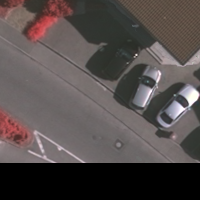

In [56]:
open_image( BASE_DIR / IMAGE_DATA_TILES_DIR / fname)

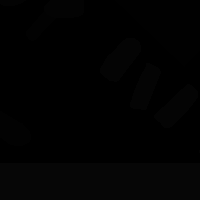

In [57]:
open_image(BASE_DIR / gt_tiles_dir / fname)

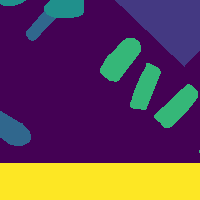

In [58]:
open_mask(BASE_DIR / gt_tiles_dir / fname)

### Load data

In [59]:
def get_y_fn(x):
    return BASE_DIR / gt_tiles_dir / x.name

In [60]:
base_path = "top_mosaic_09cm_area"
prog = re.compile(fr"{base_path}(?P<area_id>\d+)_tile(?P<tile_id>\d+).tif")

def is_in_set(x, N):
    fname = x.name  # e.g.: top_mosaic_09cm_area30_tile120.tif'

    match_result = prog.search(fname)
    area_id = match_result.group('area_id')
    tile_id = match_result.group('tile_id')
    image_fname = f"{base_path}{area_id}.tif"  # e.g.: top_mosaic_09cm_area30.tif'
    return image_fname in N

is_in_set_n1 = partial(is_in_set, N=N1)
is_in_set_n2 = partial(is_in_set, N=N2)
is_in_set_nvalidation = partial(is_in_set, N=N_validation)
is_in_set_n1_or_nvalidation = partial(is_in_set, N=N1+N_validation)

codes = LABELS+[RED, BLACK]

item_list = (SegmentationItemList.from_folder(BASE_DIR / IMAGE_DATA_TILES_DIR)  #returns SegmentationItemList
             .filter_by_func(is_in_set_n1_or_nvalidation)  #returns SegmentationItemList
             .split_by_valid_func(is_in_set_nvalidation)  #returns ItemLists(SegmentationItemList, SegmentationItemList)
             .label_from_func(get_y_fn, classes=codes)  #returns LabelLists(LabelList, SegmentationItemList)
            )

In [61]:
## DEBUG
# item_list = (SegmentationItemList.from_folder(BASE_DIR / IMAGE_DATA_TILES_DIR))

# image_segment = item_list.train.y[0]
# print(image_segment.data.shape)


# torch_vec = torch.flatten(image_segment.data)
# print(torch_vec.shape)

# # np.unique(torch_vec.numpy())
# torch_vec.unique()

In [62]:
##DEBUG
# item_list = (SegmentationItemList.from_folder(BASE_DIR / IMAGE_DATA_TILES_DIR)
#              .filter_by_func(is_in_set_n1_or_nvalidation))
# item_list

In [63]:
# ItemList.label_from_func exists
# ItemLists.
# SegmentationItemList
# ItemLists?

In [64]:
# TODO transform(get_transforms(), size=size, tfm_y=True)
# TODO make faster if I convert the labels from 3channels to 6 different integers
bs = 8
data = item_list.databunch(bs=bs).normalize(imagenet_stats)

In [65]:
data.classes

[(255, 255, 255),
 (0, 0, 255),
 (0, 255, 255),
 (0, 255, 0),
 (255, 255, 0),
 (255, 0, 0),
 (0, 0, 0)]

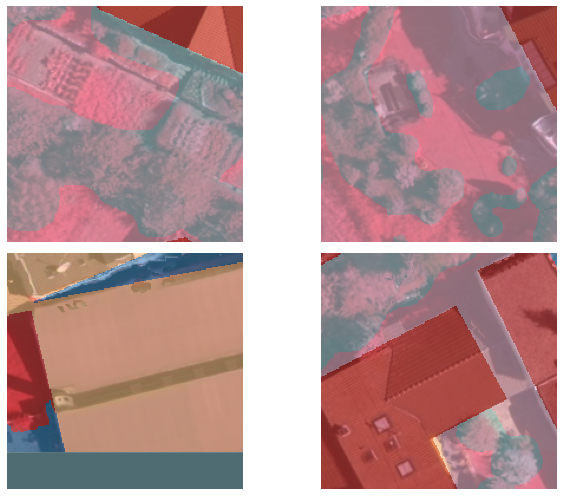

In [66]:
data.show_batch(2, figsize=(10,7))

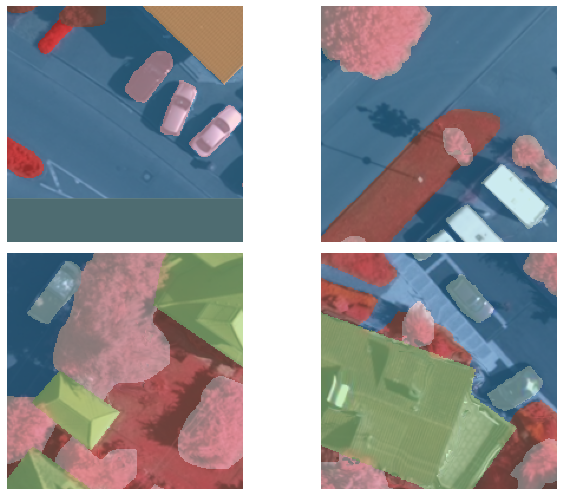

In [67]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [68]:
item_list

# all tiles: 4497
# 935 / 4497 = 20%
# 390 / 4497 = 8.6%

# This seems to be the desired split

LabelLists;

Train: LabelList (390 items)
x: SegmentationItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: SegmentationLabelList
ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200)
Path: /Users/markus/Development/weakly_superv_learning/data/ISPRS_semantic_labeling_Vaihingen/top_tiles;

Valid: LabelList (935 items)
x: SegmentationItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: SegmentationLabelList
ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200)
Path: /Users/markus/Development/weakly_superv_learning/data/ISPRS_semantic_labeling_Vaihingen/top_tiles;

Test: None

## Model

Train and compare semantic segmentation networks, using the following data: Task (i) N1 pixel level labels

In [69]:
# name2id = {v:k for k,v in enumerate(codes)}  # {WHITE:0, BLUE:1}
# void_codes_red = name2id[RED]
# void_codes_black = name2id[BLACK]

# def acc_satellite(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code_red
#     mask = target != void_code_black
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [70]:
metrics = accuracy
# metrics = acc_satellite

In [71]:
wd=1e-2

In [72]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [73]:
# Problem:
# * order of steps in datablock API -> is actually ok: (opt)filter, split, label, (opt)transform, .databunch
# * codes are different than usually

# is codes a list always, or can it be a dict?

In [ ]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
# TODO put onto GPU-machine

In [ ]:
SegmentationItemList?

In [31]:
ItemLists?